# Convolutional versus Dense layers in neural networks - Part 1

Convolutional layers in deep neural networks are known to have a dense (perceptron) equivalent. The topology of these layers is enforcing a parameter sharing : instead of copying parameters on several neurons, neurons are reused. This property of CNN is leading to a massive reduction in the number of coefficients.

In this series, we will show this property as well as some other interesting properties of CNN as compared to  the dense equivalent.

In this first part, let's design the models to be compared.

MNIST dataset of digits is well known as the initial use case of CNN by Lecun in 1998 [1].

Tensorflow's documentation has a Dense implementation [2]. Some implementation of the LeNet in Keras are also available [3], [4].

Let's review these two implementations in the light of Tensorflow 2.0

### Learning goals:
- Examplify the equivalency of the convolutional and dense networks and show the decrease in number of coefficients
- Optimize the performance of the network through regularization using Dropout layers
- Optimize the size of the networks to get a fair comparison between the Dense and Convolution DNNs

### References:
1. Gradient-Based Learning Applied to Document Recognition, Lecun et al. - http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
2. Dense implementation of the MNIST classifier - https://www.tensorflow.org/tensorboard/get_started
3. LeNet implementation with Tensorflow Keras - https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9
4. LeNet implementation with Tensorflow 1.0 - https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb
5. MNIST dataset - http://yann.lecun.com/exdb/mnist/
6. Dropout: A Simple Way to Prevent Neural Networks from Overfitting, Nitish Srivastava et al. - http://jmlr.org/papers/v15/srivastava14a.html

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, optimizers, regularizers
import seaborn as sns
import tensorview as tv

### Helpers

In [81]:
def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None,
               vmin=None, vmax=None, cbar=True):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, 
                     fmt=fmt, vmin=vmin, vmax=vmax, cbar=cbar, cmap=plt.cm.bwr, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

### MNIST Data

MNIST dataset is derived from the NIST dataset. It contains 60000 training and 10000 testing images of size 28x28 in grayscale. Digits have been recentered on the raster using the center of mass.

In [55]:
(xTrain, yTrain),(xTest, yTest) = datasets.mnist.load_data()
xTrain = xTrain / 255.0
xTest = xTest / 255.0

xTrain.shape

(60000, 28, 28)

In [96]:
metricNames = ['Categorical cross-entropy', 'Accuracy']

## Dense Model design and performance

This implementation is taken from the Tensorflow tutorial [2].

The initial 28x28 pixel image is first flattened into a a vector of 784 features. 
These features are evaluated by 512 neurons in parallel. Their outputs are activated by the ReLU before being combined into the 10 output neurons giving softmax probabilities for each of the 10 digits.

A dropout layer is inserted in between the two layers. This layer is performing regularization in order to avoid overfitting [6].

In [177]:
modelDense0 = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation=activations.relu, name='dense_0'),
        layers.Dropout(0.2),
        layers.Dense(10, activation=activations.softmax, name='dense_1')
    ])

modelDense0.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelDense0.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_47 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


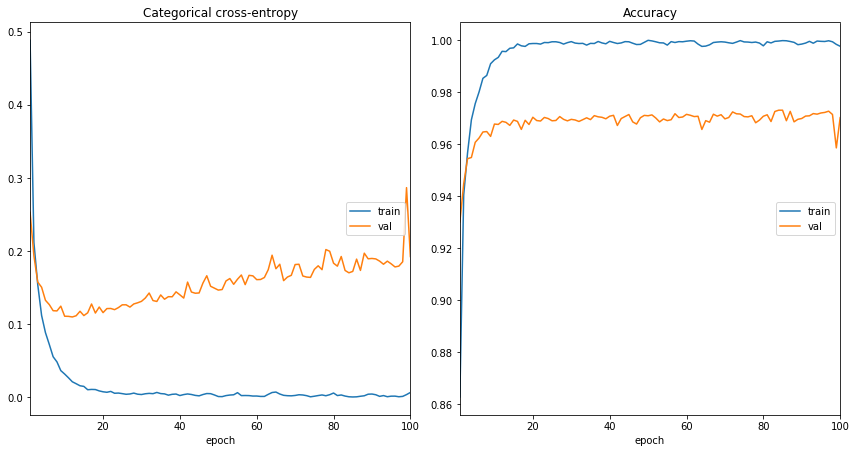

In [178]:
batchSize = 128
nEpochs = 100
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyDense0 = modelDense0.fit(xTrain, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

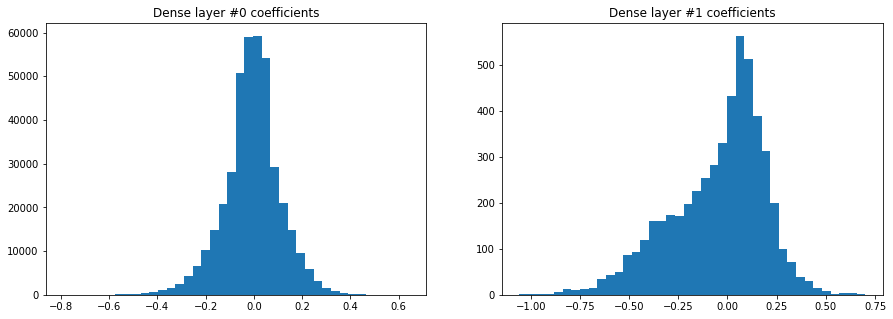

In [179]:
weightsDense0 = modelDense0.get_weights()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1], [0, 2]):
    ax.hist(weightsDense0[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

In [180]:
loss, acc = modelDense0.evaluate(xTest, yTest, verbose=0)
print("Model Dense #0, test accuracy = %.2f %%" % (acc*100))

Model Dense #0, test accuracy = 97.29 %


This model has __2 issues__:
- Even if there is regularization through the dropout layer there is still a quite large overfitting as the train and validation performance is quite different, and the validation loss is worsening from epoch 20 forward
- The variance of the validation loss and metric is high, hinting also for overfitting

## Adding more regularization to the Dense network

The flatten layer has no training coefficients (weights, bias), but is transforming the topology of the feature space and is actually the wider feature space of the network (784 for this layer versus 512 at the next layer). Let's add a Dropout layer on this feature space. Also, as advised in [6], let's change the hidden layer dropout from 20% to 50%.

In [197]:
modelDense1 = models.Sequential([
        layers.Flatten(input_shape=(28, 28), name='flatten'),
        layers.Dropout(0.2, name='dropout_0'),                             # <----
        layers.Dense(512, activation=activations.relu, name='dense_0'),
        layers.Dropout(0.5, name='dropout_1'),                             # <----
        layers.Dense(10, activation=activations.softmax, name='dense_1')
    ])

modelDense1.compile(optimizer=optimizers.Adam(),
       loss=losses.sparse_categorical_crossentropy,
       metrics=['accuracy'])

modelDense1.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_59 (Flatten)         (None, 784)               0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_54 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


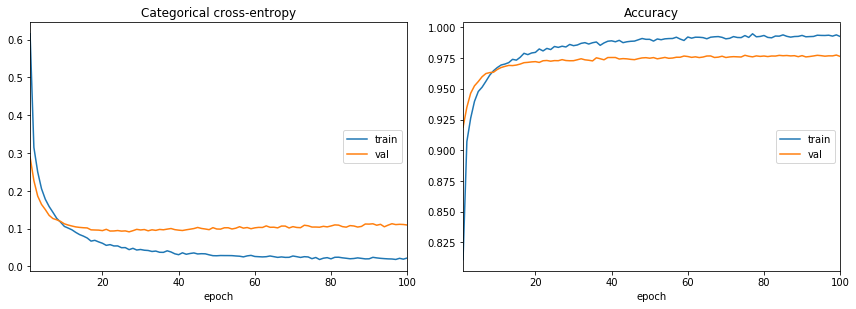

In [198]:
batchSize = 128
nEpochs = 100
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyDense1 = modelDense1.fit(xTrain, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

There is still overfitting on this network (delta between train and validation), but the variation on the validation curves are much lower and performance has increased by 0.7% (see below). The original paper on Dropout [6] is showing results better than 99% accuracy using a 2 layer dense network with 8096 units on each layer.

The validation metrics are better than the training during first epochs, this is a direct impact of the dropout: the training has fewer neurons active than the validation.

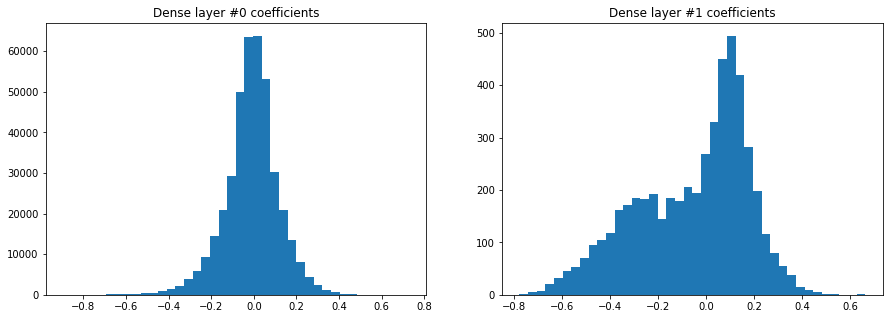

In [199]:
weightsDense1 = modelDense1.get_weights()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1], [0, 2]):
    ax.hist(weightsDense1[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

In [200]:
loss, acc = modelDense1.evaluate(xTest, yTest, verbose=0)
print("Model Dense #0, test accuracy = %.2f %%" % (acc*100))

Model Dense #0, test accuracy = 98.02 %


## Size optimized Dense model

This model seems overdesigned, many neurons are not used in layer #1. In order to have a fair comparison to the CNN implementation, let's optimize the number of neurons in layer #0.

In [201]:
batchSize = 128
nEpochs = 100

numNeuronsRange = [32, 64, 128, 256]
perfDense2 = []
for numNeurons in numNeuronsRange:
    modelDense = models.Sequential([
            layers.Flatten(input_shape=(28, 28)),
            layers.Dropout(0.2),
            layers.Dense(numNeurons, activation=activations.relu, name='dense_0'),
            layers.Dropout(0.5),
            layers.Dense(10, activation=activations.softmax, name='dense_1')
        ])

    modelDense.compile(optimizer=optimizers.Adam(),
           loss=losses.sparse_categorical_crossentropy,
           metrics=['accuracy'])

    historyDense = modelDense.fit(xTrain, yTrain,
            epochs=nEpochs, batch_size=batchSize, 
            validation_split=0.7, 
            verbose=0)
    
    perfDense2.append(modelDense.evaluate(xTest, yTest, verbose=0))
    print("Accuracy for %d neurons in layer #0 : %.2f %%" % (numNeurons, perfDense2[-1][1] * 100))

Accuracy for 32 neurons in layer #0 : 94.97 %
Accuracy for 64 neurons in layer #0 : 96.44 %
Accuracy for 128 neurons in layer #0 : 97.40 %
Accuracy for 256 neurons in layer #0 : 97.67 %


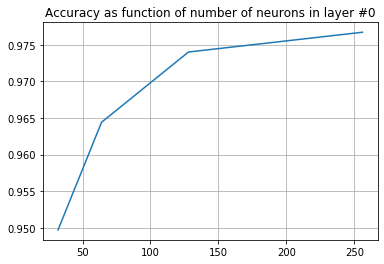

In [202]:
plt.plot(numNeuronsRange, np.array(perfDense2)[:,1])
plt.title("Accuracy as function of number of neurons in layer #0")
plt.grid()

Based on above grid search, we select the first layer to be 128 neurons wide

In [193]:
modelDense2 = models.Sequential([
            layers.Flatten(input_shape=(28, 28), name='flatten'),
            layers.Dropout(0.2, name='dropout_0'),
            layers.Dense(128, activation=activations.relu, name='dense_0'),
            layers.Dropout(0.5, name='dropout_1'),
            layers.Dense(10, activation=activations.softmax, name='dense_1')
        ])

modelDense2.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelDense2.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_58 (Flatten)         (None, 784)               0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_52 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


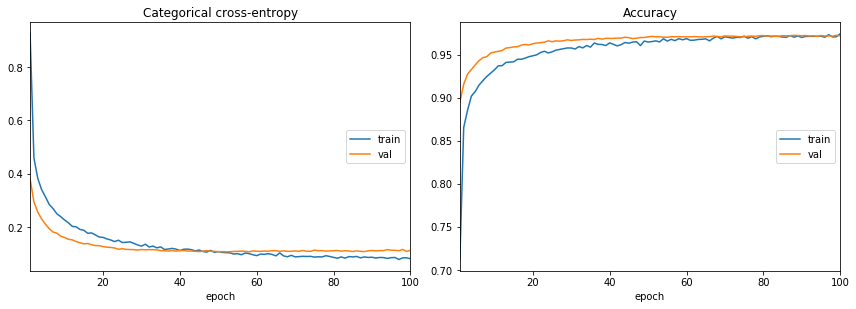

In [194]:
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyDense2 = modelDense2.fit(xTrain, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

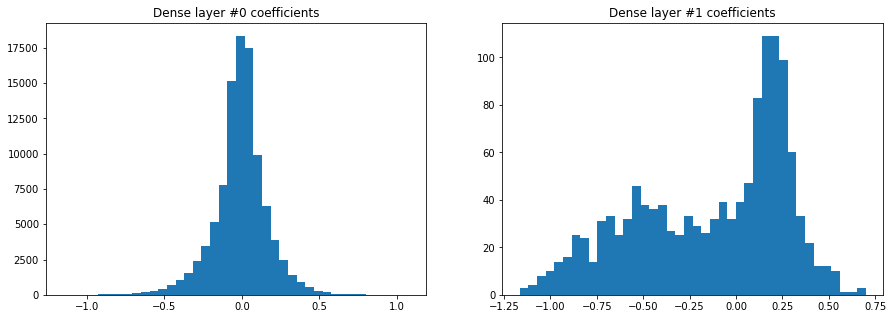

In [195]:
weightsDense2 = modelDense2.get_weights()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1], [0, 2]):
    ax.hist(weightsDense2[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

In [196]:
loss, acc = modelDense2.evaluate(xTest, yTest, verbose=0)
print("Model Dense #1, test accuracy = %.2f %%" % (acc*100))

Model Dense #1, test accuracy = 97.58 %


The performance of the optimized network is the same as the original but with a quarter of the coefficients.

## LeNet model

Adapted from [3]. 

The images are padded to reach 32x32 pixels at input of the classifier and the dimension is increased to cope with the convolution layers.

In [74]:
imagePadWidth  = 32
imagePadHeight = 32
xTrainPad  = np.pad(xTrain.reshape(-1, 28, 28, 1), ((0,0),(2,2),(2,2),(0,0)), 'constant')
xTestPad   = np.pad(xTest.reshape(-1, 28, 28, 1), ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Padded image shape: {}".format(xTrainPad[0].shape))

Padded image shape: (32, 32, 1)


In [75]:
modelLeNet0 = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation=activations.relu, 
                  input_shape=(imagePadWidth, imagePadHeight,1), name='conv_0'),
    layers.AveragePooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', name='conv_1'),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=120, activation=activations.relu, name='dense_0'),
    layers.Dense(units=84, activation=activations.relu, name='dense_1'),
    layers.Dense(units=10, activation =activations.softmax, name='dense_2')])

modelLeNet0.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelLeNet0.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_1 (Dense)              (None, 84)              

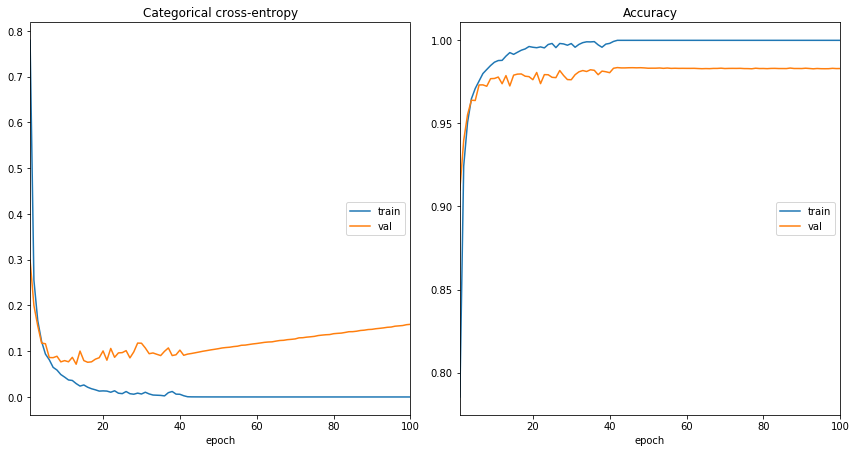

In [77]:
nEpochs = 60
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyLeNet0 = modelLeNet0.fit(xTrainPad, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

Optimization of this model is very quick. But is also overfitting and the train accuracy is reaching 100% while loss is flooring at 0.

In [79]:
loss, acc = modelLeNet0.evaluate(xTestPad, yTest, verbose=0)
print("Model LeNet #0, test accuracy = %.2f %%" % (acc*100))

Model LeNet #0, test accuracy = 98.50 %


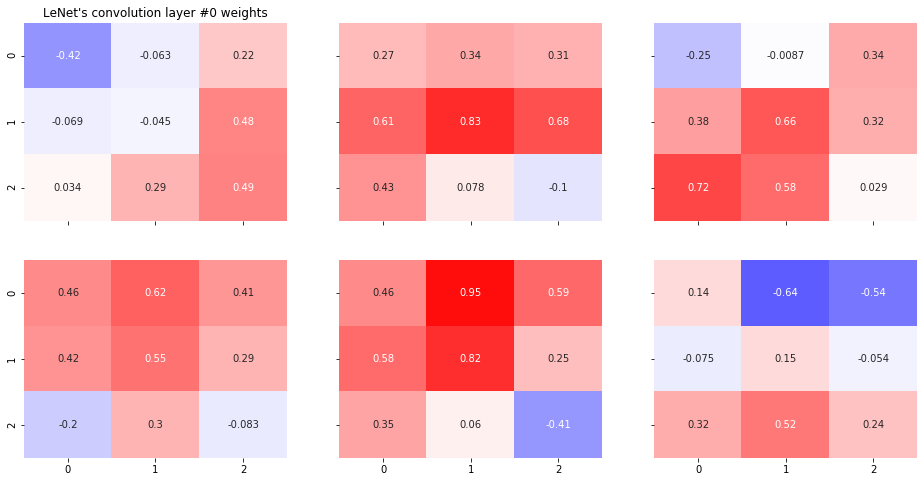

In [88]:
weightsLeNet0 = modelLeNet0.get_weights()

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(weightsLeNet0[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("LeNet's convolution layer #0 weights");

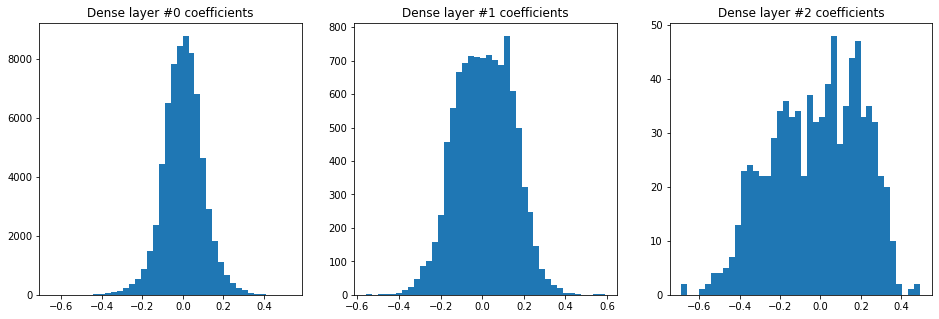

In [172]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1, 2], [4, 6, 8]):
    ax.hist(weightsLeNet0[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

### LeNet with L1-L2 regularization

In the following model, a mix of norm L1 (absolute value) and L2 (euclidian distance) is applied on the first dense layer in order to push the coefficients toward 0. This combination of regularization is also known as Elastic Net.

In [107]:
modelLeNet1 = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation=activations.relu, 
                  input_shape=(imagePadWidth, imagePadHeight,1), name='conv_0'),
    layers.AveragePooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation=activations.relu, 
                  name='conv_1'),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=120, activation=activations.relu, 
                 kernel_regularizer=regularizers.l1_l2(0.00001, 0.00001), 
                 name='dense_0'),
    layers.Dense(units=84, activation=activations.relu, 
                 kernel_regularizer=regularizers.l1_l2(0.00001, 0.00001), 
                 name='dense_1'),
    layers.Dense(units=10, activation =activations.softmax,
                 name='dense_2')])

modelLeNet1.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

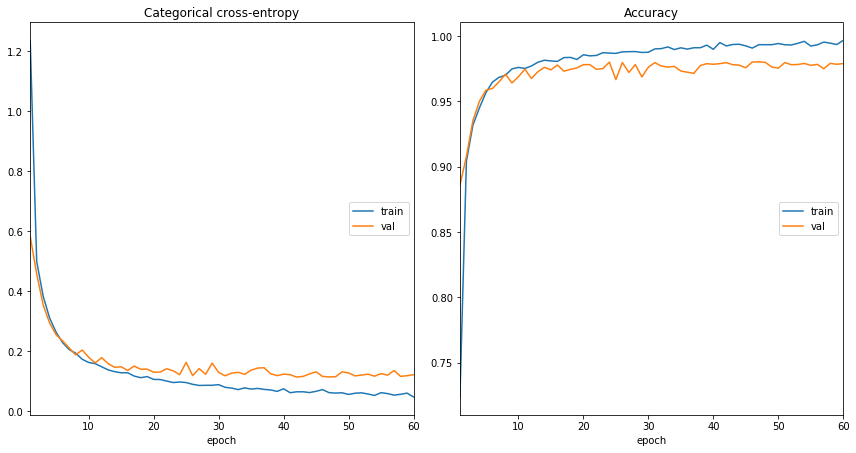

In [108]:
nEpochs = 60
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyLeNet1 = modelLeNet1.fit(xTrainPad, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

In [109]:
loss, acc = modelLeNet1.evaluate(xTestPad, yTest, verbose=0)
print("Model LeNet #1, test accuracy = %.2f %%" % (acc*100))

Model LeNet #1, test accuracy = 98.22 %


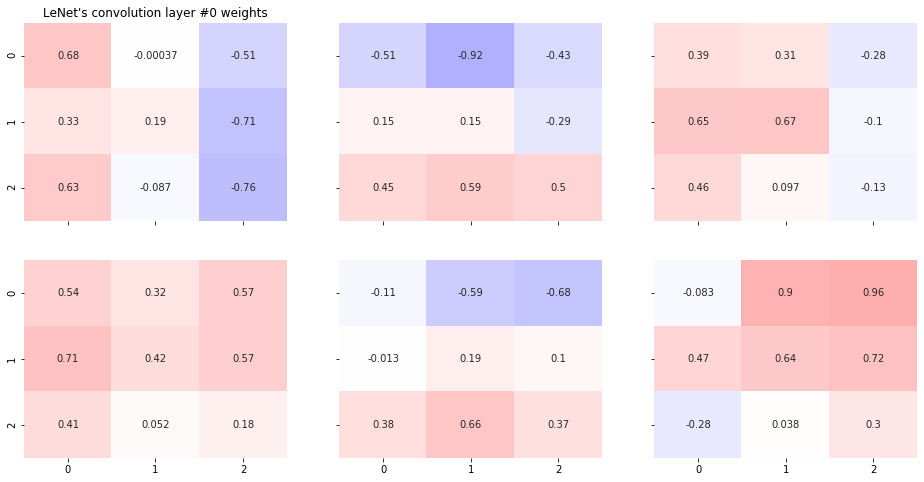

In [110]:
weightsLeNet1 = modelLeNet1.get_weights()

fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(weightsLeNet1[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("LeNet's convolution layer #0 weights");

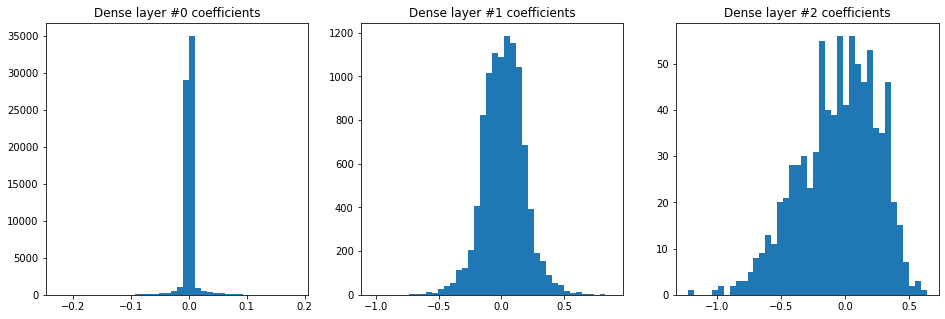

In [173]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, layerIndex, weightIndex in zip(axes, [0, 1, 2], [4, 6, 8]):
    ax.hist(weightsLeNet1[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

## Size optimized LeNet with L1-L2 regularization

In [127]:
modelLeNet2 = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation=activations.relu, 
                  input_shape=(imagePadWidth, imagePadHeight,1), name='conv_0'),
    layers.AveragePooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation=activations.relu, 
                  name='conv_1'),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=60, activation=activations.relu, 
                 kernel_regularizer=regularizers.l1_l2(0.0001, 0.0001), 
                 name='dense_0'),
    layers.Dense(units=42, activation=activations.relu, 
              #   kernel_regularizer=regularizers.l1_l2(0.00001, 0.0001), 
                 name='dense_1'),
    layers.Dense(units=10, activation =activations.softmax, 
              #   kernel_regularizer=regularizers.l1_l2(0.00001, 0.0001), 
                 name='dense_2')])

modelLeNet2.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelLeNet2.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_18 (Averag (None, 15, 15, 6)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_19 (Averag (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 60)                34620     
_________________________________________________________________
dense_1 (Dense)              (None, 42)              

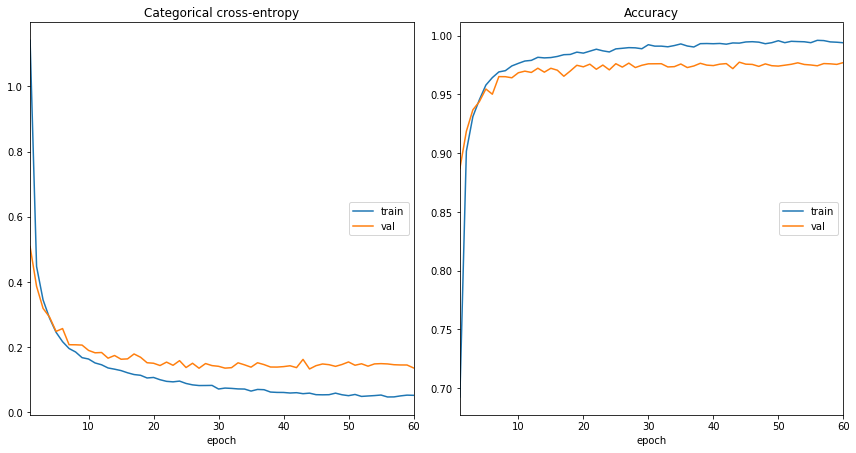

In [128]:
nEpochs = 60
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyLeNet2 = modelLeNet2.fit(xTrainPad, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0,
                callbacks=[tvPlot]);

In [129]:
loss, acc = modelLeNet2.evaluate(xTestPad, yTest, verbose=0)
print("Model LeNet #2, test accuracy = %.2f %%" % (acc*100))

Model LeNet #2, test accuracy = 97.91 %


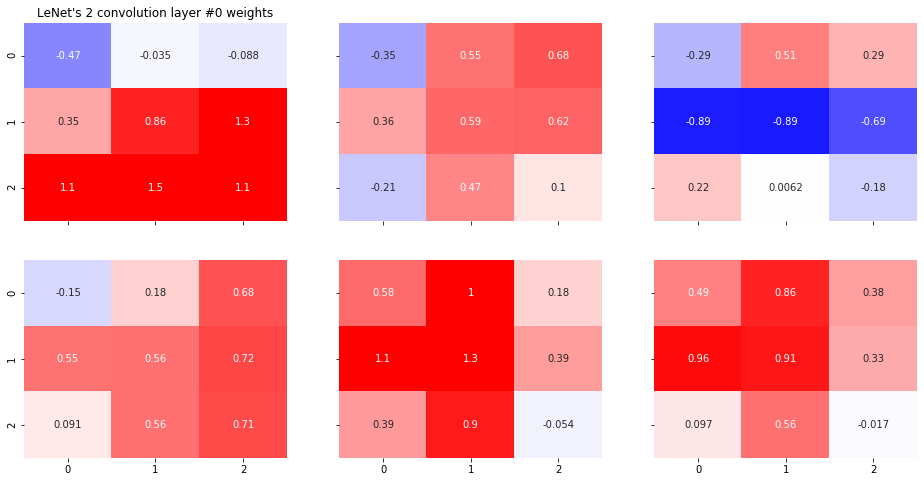

In [176]:
weightsLeNet2 = modelLeNet2.get_weights()

fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(weightsLeNet2[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("LeNet's 2 convolution layer #0 weights");

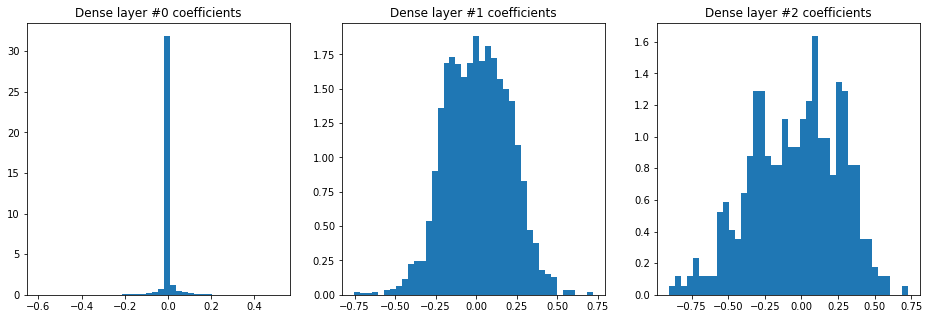

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, layerIndex, weightIndex in zip(axes, [0, 1, 2], [4, 6, 8]):
    ax.hist(weightsLeNet2[weightIndex].ravel(), density=True, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

Optimized LeNet model is matching original LeNet performance but with 29% less coefficients and less overfitting.

## Size optimized LeNet with Dropout

Dropout is another very effective regularization technic in which a share of the layer (here the convolution layer #1 with 16 neurons) is disabled at each iteration. The selection of neurons to disable is random.

In [203]:
modelLeNet3 = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation=activations.relu, 
                  input_shape=(imagePadWidth, imagePadHeight, 1), 
                  name='conv_0'),
    layers.AveragePooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation=activations.relu, 
                  name='conv_1'),
    layers.Dropout(0.2),                                 # <---
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=60, activation=activations.relu, 
                 name='dense_0'),
    layers.Dropout(0.5),                                 # <---
    layers.Dense(units=42, activation=activations.relu, 
                  name='dense_1'),
    layers.Dense(units=10, activation=activations.softmax, 
                 name='dense_2')])

modelLeNet3.compile(optimizer=optimizers.Adam(),
                   loss=losses.sparse_categorical_crossentropy,
                   metrics=['accuracy'])

modelLeNet3.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_22 (Averag (None, 15, 15, 6)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 16)        880       
_________________________________________________________________
dropout_63 (Dropout)         (None, 13, 13, 16)        0         
_________________________________________________________________
average_pooling2d_23 (Averag (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_64 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 60)              

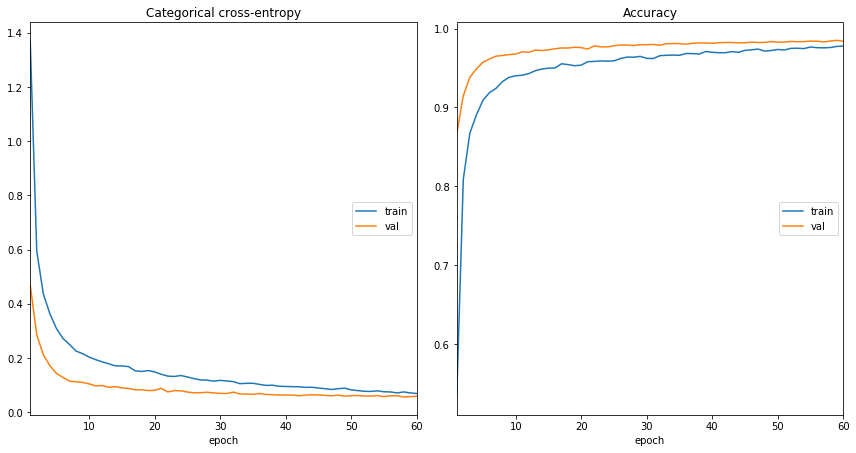

In [204]:
nEpochs = 60
tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
historyLeNet3 = modelLeNet3.fit(xTrainPad, yTrain,
                epochs=nEpochs, batch_size=batchSize, 
                validation_split=0.7, 
                verbose=0, callbacks=[tvPlot]);

In [205]:
loss, acc = modelLeNet3.evaluate(xTestPad, yTest, verbose=0)
print("Model LeNet #3, test accuracy = %.2f %%" % (acc*100))

Model LeNet #3, test accuracy = 98.59 %


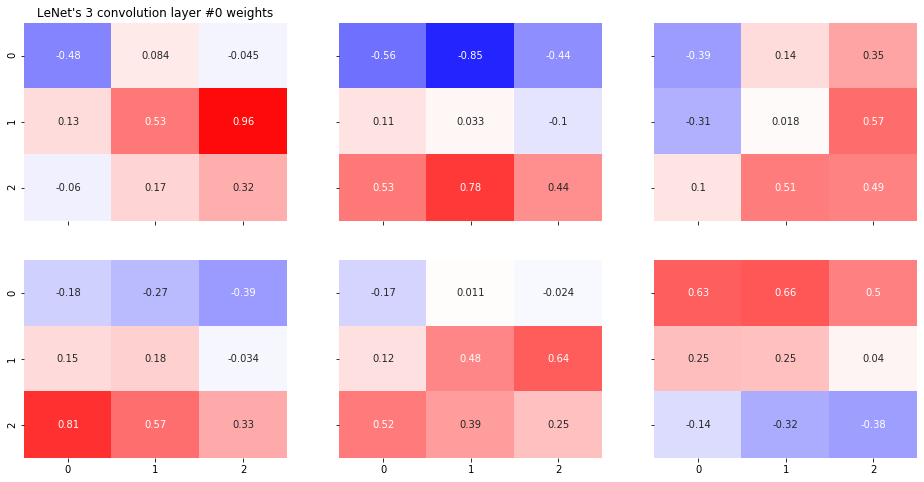

In [206]:
weightsLeNet3 = modelLeNet3.get_weights()

fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(weightsLeNet3[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("LeNet's 3 convolution layer #0 weights");

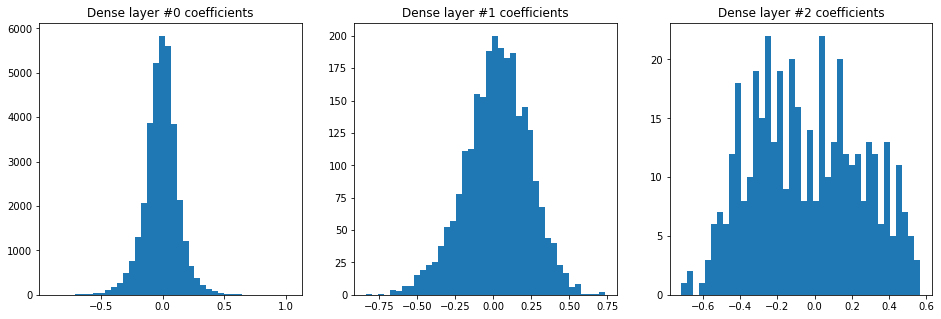

In [207]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, layerIndex, weightIndex in zip(axes, [0, 1, 2], [4, 6, 8]):
    ax.hist(weightsLeNet3[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

This model has the __best performance__ so far and 37% of the number of coefficients of the optimized dense model.